In [221]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable


from torchvision.io import read_image
from torchvision import transforms

In [8]:
src_dir = '/Users/suchetha/Downloads/samples'
img_paths = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg'))]
print("Total no of images in dataset:\t", len(img_paths))

Total no of images in dataset:	 1070


In [302]:
# img = cv2.imread(os.path.join(src_dir, img_paths[0]))
# plt.imshow(img)
# plt.title(f'Shape: {img.shape}')
# plt.show()

In [403]:
# labels_list = [img_path.split('.')[0] for img_path in img_paths]

# # Get count of each unique char
# char_counts = {}
# for label in labels_list:
#     for char in label:
#         if char not in char_counts:
#             char_counts[char] = 1
#         else:
#             char_counts[char] += 1
            
# # Sort by character
# char_counts = sorted(char_counts.items())
# print(char_counts)

In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # To supress futurewarning from pandas

# Labels
annotations_df = pd.DataFrame(columns=['image', 'label'])
for image in img_paths:
    annotations_df = annotations_df.append({"image": image, "label": image.split('.')[0]}, ignore_index=True)
    
annotations_df.to_csv("annotations_file.csv")

In [ ]:
encoding_dict = {}
i = 0
for character in string.ascii_letters.lower()[:26]:
    encoding_dict[character] = i
    i=i+1
for num in [str(j) for j in range(10)]:
    encoding_dict[num] = i
    i=i+1

## Data Loader

In [405]:
class CaptchaDataset(Dataset):
    def __init__(self,  img_dir, annotations_file, transform, encoding_dict):
        self.img_dir = img_dir
        self.encoding_dict = encoding_dict
        self.img_labels = pd.read_csv(annotations_file)
        self.transform=transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        image = image[0:3, :, :] # reduce to 3 channel
        # One hot encode the targets
        # label = fncnb, ohc_label = matrix of dim (36, 5) 
        label = self.img_labels.iloc[idx, 2]
        y = torch.zeros(36, 5)  
        for i in range(len(label)):
            y[self.encoding_dict[label[i]], i] = 1
        # y = torch.argmax(y, dim=0) #argmax along the column
        # Flatten along the columns to retain the position information. -> 36*5 = 180
        y = y.transpose(1, 0).flatten()
        if self.transform:
            image = self.transform(image)
        return image, y
        
    def __len__(self):
        return len(self.img_labels)

In [406]:
img_dir = '/Users/suchetha/Downloads/Samples'
annotations_file = '/Users/suchetha/annotations_file.csv'

transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
captcha_dataset = CaptchaDataset(img_dir, annotations_file, transform=transform, encoding_dict=encoding_dict)

Feature batch shape: torch.Size([10, 3, 50, 200])
Labels batch shape: torch.Size([10, 180])
----------



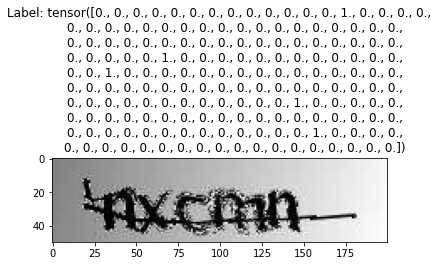

In [407]:
dataset_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size = 10, shuffle = True, num_workers=0)

features, labels = next(iter(dataset_loader))

print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
print("----------\n")

img = features[0].squeeze()
label = labels[0]
plt.imshow(transforms.ToPILImage()(img))
plt.title(f"Label: {label}")
plt.show()

## Train & Test data

In [408]:
validation_split = 0.2
shuffle_dataset = True
random_seed = 7
batch_size = 30

dataset_size = len(captcha_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(captcha_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [409]:
len(train_indices)

856

## Network

In [410]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 47, 240)
        self.fc2 = nn.Linear(240, 180)

    def forward(self, x):
        # print("x", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print("x", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print("x", x.size())
        x = x.view(-1, 16 * 9 * 47)
        # print("x", x.size())
        x = F.relu(self.fc1(x))
        # print("x", x.size())
        x = F.relu(self.fc2(x))
        # x = torch.nn.Softmax(x)
        
        # print("x", x.size())
        # print("----------")
        return x


net = Net()
# criterion = nn.CrossEntropyLoss()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [497]:
train_loss = []
for epoch in range(10):  
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print('eopch:', epoch+1, 'batch_idx:', batch_idx+1, 'loss:', loss.item())
        
        


eopch: 1 batch_idx: 1 loss: 0.6985058188438416
eopch: 1 batch_idx: 2 loss: 0.6984856724739075
eopch: 1 batch_idx: 3 loss: 0.6983066201210022
eopch: 1 batch_idx: 4 loss: 0.698367178440094
eopch: 1 batch_idx: 5 loss: 0.6983193755149841
eopch: 1 batch_idx: 6 loss: 0.6982586979866028
eopch: 1 batch_idx: 7 loss: 0.6982627511024475
eopch: 1 batch_idx: 8 loss: 0.6983233094215393
eopch: 1 batch_idx: 9 loss: 0.6981721520423889
eopch: 1 batch_idx: 10 loss: 0.697995126247406
eopch: 1 batch_idx: 11 loss: 0.6981279850006104
eopch: 1 batch_idx: 12 loss: 0.698093831539154
eopch: 1 batch_idx: 13 loss: 0.6980361342430115
eopch: 1 batch_idx: 14 loss: 0.6980631351470947
eopch: 1 batch_idx: 15 loss: 0.6979846954345703
eopch: 1 batch_idx: 16 loss: 0.6979491710662842
eopch: 1 batch_idx: 17 loss: 0.697960615158081
eopch: 1 batch_idx: 18 loss: 0.6977338194847107
eopch: 1 batch_idx: 19 loss: 0.6977828145027161
eopch: 1 batch_idx: 20 loss: 0.6977128386497498
eopch: 1 batch_idx: 21 loss: 0.6978614330291748
eopch

## Test

In [498]:
def decode(labels):
    one = torch.argmax(labels[:, 0:36], axis=1)
    two = torch.argmax(labels[:, 36:36*2], axis=1)
    three = torch.argmax(labels[:, 36*2:36*3], axis=1)
    four = torch.argmax(labels[:, 36*3:36*4], axis=1)
    five = torch.argmax(labels[:, 36*4:36*5], axis=1)
    
    prediction_values = torch.transpose(torch.vstack((one, two, three, four, five)),0,1).tolist()
    
    pred_char = []
    for pred_val in prediction_values:
        pred_chars = []
        for p in pred_val:
            for key, values in encoding_dict.items():
                if p==values:
                    pred_chars.append(key)
        pred_char.append(pred_chars)
        
    return pred_char

In [499]:
correct = 0
total = 0
for data in validation_loader:
    images, labels = data
    outputs = net(Variable(images))
    labels_decoded = decode(labels)
    outputs_decoded = decode(outputs)  
    for i in range(len(labels_decoded)):
        truth = ''.join(labels_decoded[i])
        pred = ''.join(outputs_decoded[i])
        if truth==pred:
            correct += 1
    total += labels.size(0)

print(correct/total)

0.0
